In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from CNN import Net

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# Read a sample Image for the progress | Equation
eq = cv2.imread('Equation.png')

In [3]:
# Perspective Correction
# Conversion to GrayScale before passing it to Canny Edge Detection
# gray = cv2.cvtColor(eq, cv2.COLOR_BGR2GRAY)
# # Canny Edge Detection - Gradient < Threshold1 (Not Considered as an Edge) | Gradient > Threshold (Considered as an Edge)
# edges = cv2.Canny(gray, 100, 200)
# # Hough Transform - Finds the Lines and Circles in an Image
# lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold = 80,minLineLength = 10, maxLineGap = 20)
# # Drawing Lines over the Edge Image
# copy = eq.copy()
# # List contains all the points (x, y)
# list = np.empty((0, 1, 2))
# for points in lines :
#     x1, y1, x2, y2 = points[0]
#     list = np.append(list, [[[x1, y1]]], axis = 0)
#     list = np.append(list, [[[x2, y2]]], axis = 0)
#     cv2.line(copy, (x1, y1), (x2, y2), (255, 0, 0), 1)
# Determining the Four Corners of the WhiteBoard

In [10]:
eq = np.float64(eq)
tic = cv2.cornerHarris(eq, 2, 3, 0.04) #The parameters are chosen from the official doc of cv2.cornerHarris()
cpy = np.zeros((eq.shape[0], eq.shape[1]), dtype = np.uint8)
cpy[tic > 0 * tic.max()] = [255]
plt.imshow(cpy, cmap = 'gray')
plt.show()

error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgproc/src/corner.cpp:254: error: (-215:Assertion failed) src.type() == CV_8UC1 || src.type() == CV_32FC1 in function 'cornerEigenValsVecs'


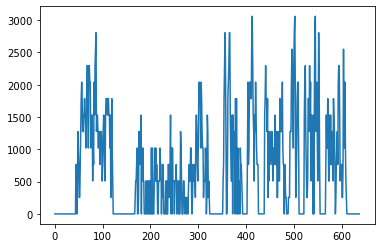

In [47]:
hist = np.sum(cpy, axis = 0, keepdims = True)
plt.plot(np.arange(cpy.shape[1]), hist[0])
plt.show()

In [69]:
class PreProcess :
    # Binarize
    @staticmethod
    def Binarize(img) :
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return cv2.threshold(img, 60, 255, cv2.THRESH_BINARY_INV)[1]
    #Focus Crop
    # Skipping the part of Perspective Correction assuming that the Images given are at straight perspective
    # How do we crop to the focus of the equations in an Image ... ?
    # Harris Features help us find the corners of the Image
    def FocusCrop(self, img) :
        img = np.float32(img) # Conversion of Image array to 32 bit precision for compatibility of cv2.cornerHarris()
        corners = cv2.cornerHarris(eq, 2, 3, 0.04) # The parameters are chosen from the official doc of cv2    .cornerHarris()
        # Creating a Dummy Image inorder to Threshold
        dmy = np.zeros((eq.shape[0], eq.shape[1]), dtype = np.uint8)
        dmy[corners > 0.05 * corners.max()] = [255]
        # Checking for the Central Cluster containing Content
        return img
    # Extraction of Characters from the Equation | Segmentation - Connected Component Analysis
    # https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/
    def Segment(img) :
        return img

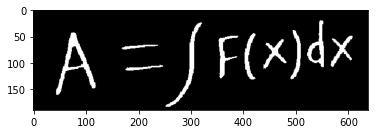

In [72]:
PreProcessor = PreProcess()
eq = PreProcessor.Binarize(eq)
# Visualizing the Binary Image
plt.imshow(eq, cmap='gray')
plt.show()

In [ ]:
# The Following Code was used to Generate an Tensor DataSet
# Data for CNN Classifier | 57 Characters | 64 x 64
img = np.loadtxt('DataSet/DataMatrix4D.txt', dtype = 'i', delimiter = ',')
label = np.loadtxt('DataSet/LabelMatrix.txt', dtype = 'i', delimiter = ',')
# Conversion of DataSet to Tensor
img_tensor = torch.zeros((12869, 1, 64, 64))
for i in range(img_tensor.shape[0]) :
    for j in range(img_tensor.shape[2]) :
        for k in range(img_tensor.shape[3]) :
            img_tensor[i, 0, k, j] = img[i, k + 64*j]
label = torch.tensor(label)
# PyTorch Doesn't Accept FloatTensor as Categorical Target
label = label.type(torch.LongTensor)
# Since Labelling starts from 1
label  = label - 1
# Saving the Tensor inorder to reduce the Time of Computation every time
torch.save(img_tensor, 'DataSet/Image.pt')
torch.save(label, 'DataSet/Label.pt')

In [3]:
# Loading the Saved Tensor Variable
img = torch.load('DataSet/Image.pt')
label = torch.load('DataSet/Label.pt')

In [4]:
# Shape of the DataSet
print(f'Shape of Image DataSet : {img.shape}')
print(f'Shape of Labels : {label.shape}')

Shape of Image DataSet : torch.Size([12869, 1, 64, 64])
Shape of Labels : torch.Size([12869])


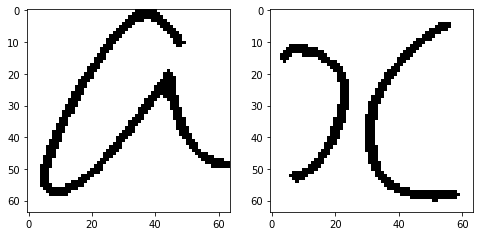

In [7]:
# Visualizing few Images from the DataSet
plt.figure(figsize = (8, 18))
plt.subplot(1, 2, 1)
plt.imshow(img[0][0], cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(img[1500][0], cmap = 'gray')
plt.show()

In [8]:
# Creating an DataSet as Pair of Images and Target Variable
DataSet = TensorDataset(img, label)
# Splitting the DataSet into Batches using DataLoader
Dataloader = DataLoader(DataSet, batch_size = 64, shuffle = True)

In [9]:
# Visualizing the Architecture of the CNN
model = Net()
summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
              ReLU-2           [-1, 16, 64, 64]               0
         MaxPool2d-3           [-1, 16, 32, 32]               0
         Dropout2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
         Dropout2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
             ReLU-10           [-1, 64, 16, 16]               0
        MaxPool2d-11             [-1, 64, 8, 8]               0
        Dropout2d-12             [-1, 64, 8, 8]               0
           Linear-13                 [-1, 1024]       4,195,328
             ReLU-14                 [-

In [13]:
# Training the above defined CNN Classifier
# Optimizer is being changed from Adam to SGD
def fit(Dataloader, EPOCH) :
    optimizer = optim.SGD(model.parameters(), lr = 0.01)
    criterion = nn.CrossEntropyLoss()
    for index in range(EPOCH) :
        for img, label in Dataloader :
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.zero_grad()
            optimizer.step()
            # print(f'Loss : {loss.item()}')
    torch.save(model, 'Model.pt')
    print('Model Save Successfully!')

In [14]:
fit(Dataloader, 3)

Loss : 4.0501203536987305
Loss : 4.0371317863464355
Loss : 4.032526016235352
Loss : 4.03399658203125
Loss : 4.039038181304932
Loss : 4.029310703277588
Loss : 4.026706218719482
Loss : 4.051414966583252
Loss : 4.049609184265137
Loss : 4.040925979614258
Loss : 4.038378715515137
Loss : 4.044058322906494
Loss : 4.034142971038818
Loss : 4.053749084472656
Loss : 4.049622058868408
Loss : 4.051260948181152
Loss : 4.04445219039917
Loss : 4.041888236999512
Loss : 4.021420955657959
Loss : 4.045919418334961
Loss : 4.031072616577148
Loss : 4.0221099853515625
Loss : 4.0311408042907715
Loss : 4.038139820098877
Loss : 4.0364179611206055
Loss : 4.038509845733643
Loss : 4.05034065246582
Loss : 4.0349626541137695
Loss : 4.038851261138916
Loss : 4.043622016906738
Loss : 4.04015588760376
Loss : 4.0431952476501465
Loss : 4.041045188903809
Loss : 4.046448707580566
Loss : 4.045434951782227
Loss : 4.032778739929199
Loss : 4.041706562042236
Loss : 4.039622783660889
Loss : 4.040455341339111
Loss : 4.0394082069396

In [15]:
# Reading the Model
# torch.unsqueeze() is used inorder to get an extra dimension as during training we give it as batches
# while here we give it as a single image which causes dimensionality change.
model = torch.load('Model.pt')
model.eval()
with torch.no_grad() :
    prd = model(torch.unsqueeze(img[0], 0))
# cls = F.softmax(prd, dim = -1)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [16]:
torch.max(prd, 1)

torch.return_types.max(
values=tensor([0.0928]),
indices=tensor([5]))